In [1]:
import os
import sys
import time

import numpy as np
from matplotlib import pyplot as plt

from ale_py import ALEInterface
import pygame

from IPython.display import clear_output   

pygame 2.1.2 (SDL 2.0.18, Python 3.9.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


## ROM Prep

In [2]:
rom_file = "/Users/aldo/workspace/202201_cs5340/_project/_rom/breakout.bin"

In [3]:
ale = ALEInterface()
ale.setInt("random_seed", 42)
ale.setFloat("repeat_action_probability", 0)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


In [4]:
# Load Roms
ale.loadROM(rom_file)

Game console created:
  ROM file:  /Users/aldo/workspace/202201_cs5340/_project/_rom/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 42


In [5]:
# Get the list of legal actions
legal_actions = ale.getLegalActionSet()
minimal_actions = ale.getMinimalActionSet()
print(legal_actions)
print(minimal_actions)

[<Action.NOOP: 0>, <Action.FIRE: 1>, <Action.UP: 2>, <Action.RIGHT: 3>, <Action.LEFT: 4>, <Action.DOWN: 5>, <Action.UPRIGHT: 6>, <Action.UPLEFT: 7>, <Action.DOWNRIGHT: 8>, <Action.DOWNLEFT: 9>, <Action.UPFIRE: 10>, <Action.RIGHTFIRE: 11>, <Action.LEFTFIRE: 12>, <Action.DOWNFIRE: 13>, <Action.UPRIGHTFIRE: 14>, <Action.UPLEFTFIRE: 15>, <Action.DOWNRIGHTFIRE: 16>, <Action.DOWNLEFTFIRE: 17>]
[<Action.NOOP: 0>, <Action.FIRE: 1>, <Action.RIGHT: 3>, <Action.LEFT: 4>]


## Simulate Game

In [6]:
### Reset and Prep Screen and RAM Data
ram_size = ale.getRAMSize()
ram = np.zeros((ram_size),dtype=np.uint8)
ale.getRAM(ram)

(screen_width,screen_height) = ale.getScreenDims()
screen_data = np.zeros((screen_width,screen_height,3),dtype=np.uint8)
ale.getScreenRGB(screen_data)

(screen_width,screen_height) = ale.getScreenDims()
screen_data = np.zeros((screen_width,screen_height),dtype=np.uint8)
ale.getScreen(screen_data)

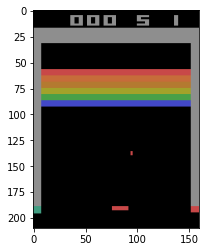

Action.LEFT


KeyboardInterrupt: 

In [7]:
### Simulate Randomize Game Playing
### Note: NOOP and FIRE does nothing. Only LEFT and RIGHT does.
### Note: Doing it this way is really slow because of the clear_output

total_reward = 0.0
ale.reset_game()  
while not ale.game_over():
    start_time = time.time()
    a = minimal_actions[np.random.randint(len(minimal_actions))]
    reward = ale.act(a);
    frame = ale.getScreenRGB()
    #print("--- Generate next frame: %s seconds ---" % (time.time() - start_time)) 

    plt.imshow(ale.getScreenRGB())
    plt.show()
    print(a)
    #print(ale.getRAM())
    
    clear_output(wait=True)

### Performance Exploration

In [8]:
# How long each frame generation might take on average?
time_frame = []
ale.reset_game()  
while not ale.game_over():
    start_time = time.time()
    a = minimal_actions[np.random.randint(len(minimal_actions))]
    reward = ale.act(a);
    frame = ale.getScreenRGB()
    time_frame.append(time.time() - start_time)
    
mean_time_frame = np.mean(np.array(time_frame))
print("Action + Generate Frames Take: " + str(mean_time_frame) + "s, or " + str(1/mean_time_frame) + " FPS")

Action + Generate Frames Take: 0.0003083055831966329s, or 3243.53516284593 FPS


In [9]:
# How long does each state cloning and restoring might take on average?
 
time_clone = []
time_restore = []
ale.reset_game()  
while not ale.game_over():
    start_time = time.time()
    
    # Do a random action twice, cloning in between and restore after
    a = minimal_actions[np.random.randint(len(minimal_actions))]
    reward = ale.act(a);
    
    start_time = time.time()
    state = ale.cloneState()
    time_clone.append(time.time() - start_time)
    
    a = minimal_actions[np.random.randint(len(minimal_actions))]
    reward = ale.act(a);
    
    start_time = time.time()
    ale.restoreState(state)
    frame = ale.getScreenRGB()
    time_restore.append(time.time() - start_time)
    
mean_time_clone = np.mean(np.array(time_clone))
print("Clone Time: " + str(mean_time_clone) + "s, or " + str(1/mean_time_clone) + " FPS")
mean_time_restore = np.mean(np.array(time_restore))
print("Restore Time: " + str(mean_time_restore) + "s, or " + str(1/mean_time_restore) + " FPS")

Clone Time: 0.00018802140989611225s, or 5318.543247561709 FPS
Restore Time: 0.0004375687529963832s, or 2285.3551428254423 FPS


In [11]:
# How long does all the steps of cloning and restoring might take on average?
# Includes resetting the game, cloning/restoring the state, doing action, and getting the frame

time_clone = []
time_restore = []
for i in range(50):
    ale.reset_game()
    a_init = minimal_actions[np.random.randint(len(minimal_actions))]
    start_time = time.time()
    state = ale.cloneState(include_rng=True)
    reward = ale.act(a_init);
    frame_init = np.array(ale.getScreenRGB())
    time_clone.append(time.time() - start_time)
    
    for i in range(10):
        a = minimal_actions[np.random.randint(len(minimal_actions))]
        reward = ale.act(a);
        frame = ale.getScreenRGB()
    
    start_time = time.time()
    #ale.reset_game()
    ale.restoreState(state)
    ale.act(a_init);
    frame_new = np.array(ale.getScreenRGB())
    time_restore.append(time.time() - start_time)
    
mean_time_clone = np.mean(np.array(time_clone))
print("Full Clone Time: " + str(mean_time_clone) + "s, or " + str(1/mean_time_clone) + " FPS")
mean_time_restore = np.mean(np.array(time_restore))
print("Full Restore Time: " + str(mean_time_restore) + "s, or " + str(1/mean_time_restore) + " FPS")

Full Clone Time: 0.0008849620819091797s, or 1129.9919176679778 FPS
Full Restore Time: 0.0010762834548950196s, or 929.1232671578508 FPS


0.0


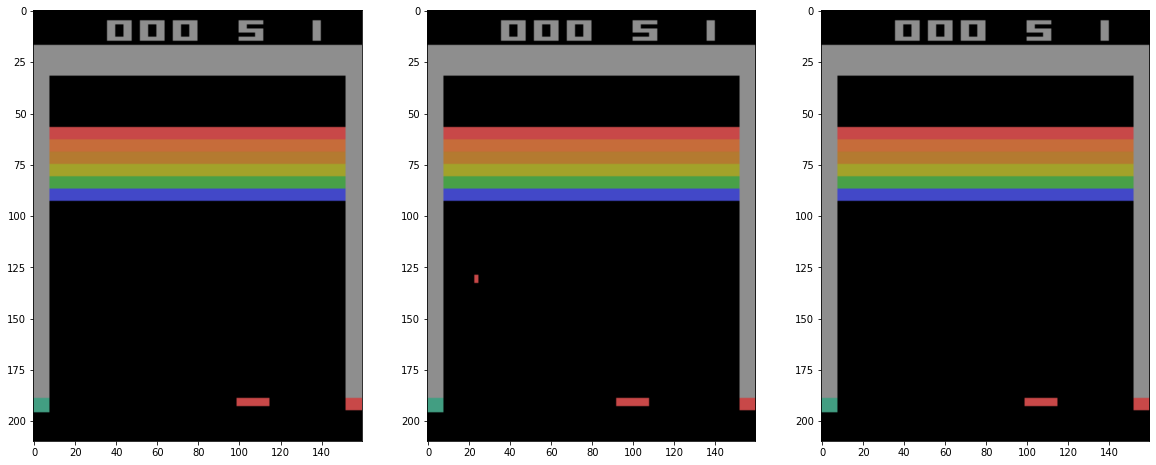

In [12]:
# How does state clone and restore work?

ale.reset_game()
a_init = minimal_actions[np.random.randint(len(minimal_actions))]
state = ale.cloneState(include_rng=True)
reward = ale.act(a_init);
frame_init = np.array(ale.getScreenRGB())

for i in range(10):
    a = minimal_actions[np.random.randint(len(minimal_actions))]
    reward = ale.act(a);
    frame = ale.getScreenRGB()

ale.restoreState(state)
ale.act(a_init);
frame_new = np.array(ale.getScreenRGB())

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(frame_init)
ax2.imshow(frame)
ax3.imshow(frame_new)

print(np.linalg.norm(frame_new - frame_init))

In [ ]:
# Test Capability of Clone and Restore (Start vs End)

norm = []
for i in range(1000):
    ale.reset_game()
    a_init = minimal_actions[np.random.randint(len(minimal_actions))]
    state = ale.cloneState(include_rng=True)
    reward = ale.act(a_init);
    frame_init = np.array(ale.getScreenRGB())
    
    for i in range(5):
        a = minimal_actions[np.random.randint(len(minimal_actions))]
        reward = ale.act(a);
        frame = ale.getScreenRGB()
    
    ale.restoreState(state)
    ale.act(a_init);
    frame_new = np.array(ale.getScreenRGB())

    norm_val = np.linalg.norm(frame_new - frame_init)
    norm.append(norm_val)
    
    if (norm_val > 0):
        print(norm_val)
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
        ax1.imshow(frame_init)
        ax2.imshow(frame)
        ax3.imshow(frame_new)
        
print(np.mean(np.array(norm)))

In [ ]:
# Test Capability of Clone and Restore (Middle of Process vs End) 

norm = []
for i in range(1000):
    ale.reset_game()
    a_init = minimal_actions[np.random.randint(len(minimal_actions))]
    state = ale.cloneState(include_rng=True)
    reward = ale.act(a_init);
    frame_init = np.array(ale.getScreenRGB())
    
    for i in range(10):
        a = minimal_actions[np.random.randint(len(minimal_actions))]
        state = ale.cloneState(include_rng=True)
        reward = ale.act(a);
        frame = ale.getScreenRGB()
    
    reward = ale.act(a);
    ale.restoreState(state)
    ale.act(a);
    frame_new = np.array(ale.getScreenRGB())
    
    norm_val = np.linalg.norm(frame_new - frame)
    norm.append(norm_val)
    
    if (norm_val > 0):
        print(norm_val)
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
        ax1.imshow(frame_init)
        ax2.imshow(frame)
        ax3.imshow(frame_new)
    
print(np.mean(np.array(norm)))

### Generate Multiple Future Frames